In [1]:
# !pip install "numpy<1.23" scipy

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.xception import Xception # type: ignore
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models, losses, optimizers

Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3000)]
        )

In [4]:
img = load_img("./data/train/ambarella/ambarella_00003.jpg", target_size=(150,150))

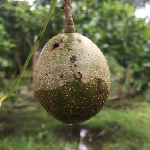

In [5]:
img

In [6]:
np.array(img).shape

(150, 150, 3)

# Train model

In [7]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    './data/train',
    target_size=(150, 150),
    batch_size=20
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    './data/test',
    target_size=(150, 150),
    batch_size=20,
    shuffle=False
)

Found 513 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


Hyperparameter i will try:
- inner dense layer size
- learning rate
- epochs(using checkpoint)

And try another model if i have enough time

# Learning rate Optimize

In [8]:
scores = {}
def make_model(
        base_model = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(150, 150, 3)
        ),
        dense_inner_size = 64,
        learning_rate = 0.001
):
    
    ########################
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training = False)
    vectors = layers.GlobalAveragePooling2D()(base)
    inner = layers.Dense(dense_inner_size, activation='relu')(vectors)
    outputs = layers.Dense(5)(inner)
    model = keras.Model(inputs, outputs)

    '][==]'
    ########################
    
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    loss = losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

for lr in [1e-6,1e-5,1e-4]:
    print("Learning rate: ", lr)
    model = make_model(
        learning_rate=lr
    )
    history = model.fit(train_ds, epochs = 20, validation_data = val_ds)
    scores[lr] = history.history


Learning rate:  1e-06
Epoch 1/20
26/26 [==============================] - 20s 375ms/step - loss: 1.6675 - accuracy: 0.2320 - val_loss: 1.6089 - val_accuracy: 0.4400
Epoch 2/20
26/26 [==============================] - 6s 238ms/step - loss: 1.4694 - accuracy: 0.3801 - val_loss: 1.4813 - val_accuracy: 0.5400
Epoch 3/20
26/26 [==============================] - 6s 238ms/step - loss: 1.3057 - accuracy: 0.5712 - val_loss: 1.3652 - val_accuracy: 0.5800
Epoch 4/20
26/26 [==============================] - 6s 238ms/step - loss: 1.1602 - accuracy: 0.6940 - val_loss: 1.2511 - val_accuracy: 0.6300
Epoch 5/20
26/26 [==============================] - 6s 239ms/step - loss: 1.0255 - accuracy: 0.7973 - val_loss: 1.1330 - val_accuracy: 0.6800
Epoch 6/20
26/26 [==============================] - 6s 239ms/step - loss: 0.8997 - accuracy: 0.8635 - val_loss: 1.0177 - val_accuracy: 0.7200
Epoch 7/20
26/26 [==============================] - 6s 239ms/step - loss: 0.7808 - accuracy: 0.9201 - val_loss: 0.9013 - val_

In [9]:
lrs = list(scores.keys())
for lr in lrs:
    print(f"Learning rate: {lr}, ")
    print(f"Average val_accuracy: {np.average(scores[lr]['val_accuracy'])}")



Learning rate: 1e-06, 
Average val_accuracy: 0.8524999976158142
Learning rate: 1e-05, 
Average val_accuracy: 0.9890000104904175
Learning rate: 0.0001, 
Average val_accuracy: 0.9875000089406967


In [10]:
scores

{1e-06: {'loss': [1.6675442457199097,
   1.4694288969039917,
   1.305742859840393,
   1.1601554155349731,
   1.025536298751831,
   0.8996758460998535,
   0.780754566192627,
   0.6705752015113831,
   0.5685078501701355,
   0.47608238458633423,
   0.3967008888721466,
   0.32801494002342224,
   0.26960623264312744,
   0.2229790836572647,
   0.1837964802980423,
   0.15245655179023743,
   0.12713848054409027,
   0.10653415322303772,
   0.08953966200351715,
   0.07572443783283234],
  'accuracy': [0.23196880519390106,
   0.3801169693470001,
   0.5711501240730286,
   0.6939570903778076,
   0.7972709536552429,
   0.8635477423667908,
   0.9200779795646667,
   0.955165684223175,
   0.9824561476707458,
   0.9941520690917969,
   0.9961013793945312,
   0.9961013793945312,
   0.9980506896972656,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'val_loss': [1.6089190244674683,
   1.4812778234481812,
   1.365237832069397,
   1.2510902881622314,
   1.1330485343933105,
   1.0176587104797363,
  

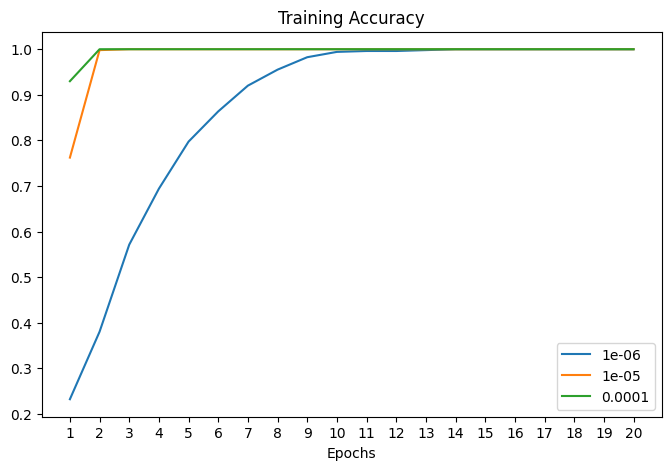

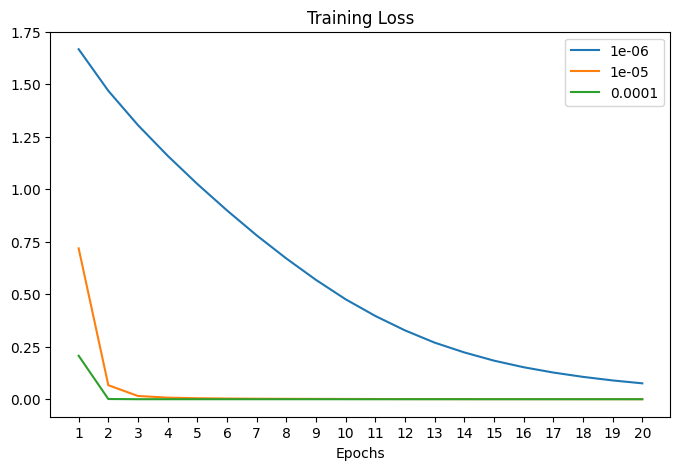

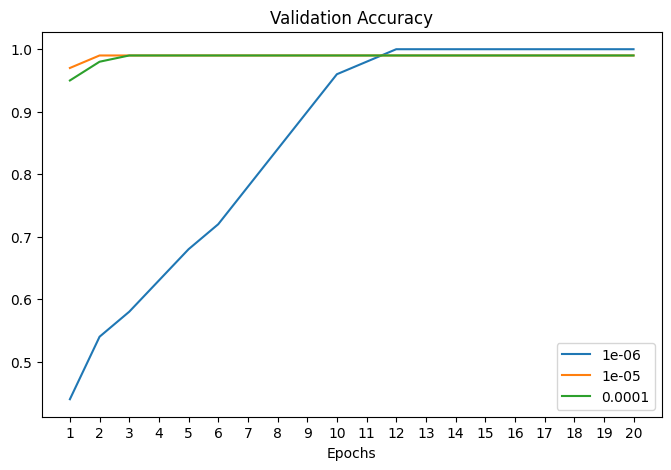

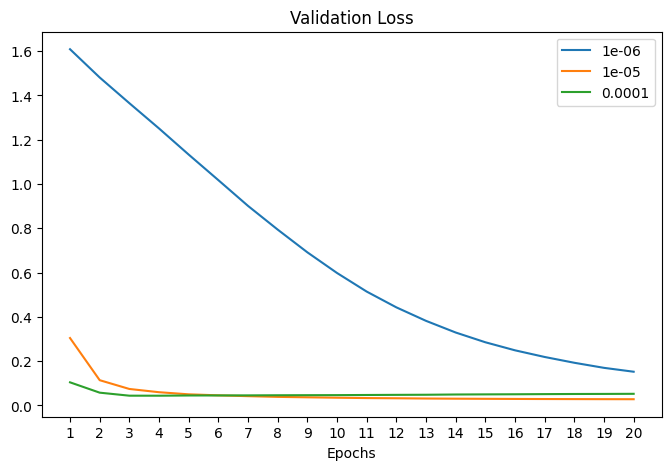

In [11]:
def plotting_metrics(scores):
    epochs = list(range(1,21))

    plt.figure(figsize=(8, 5))  # Set the figure size
    for lr in scores.keys():
        plt.plot(epochs, scores[lr]['accuracy'], label = f'{lr}')
    plt.title("Training Accuracy")
    plt.xlabel("Epochs")
    plt.xticks(epochs)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))  # Set the figure size
    for lr in scores.keys():
        plt.plot(epochs, scores[lr]['loss'], label = f'{lr}')
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.xticks(epochs)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))  # Set the figure size
    for lr in scores.keys():
        plt.plot(epochs, scores[lr]['val_accuracy'], label = f'{lr}')
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.xticks(epochs)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))  # Set the figure size
    for lr in scores.keys():
        plt.plot(epochs, scores[lr]['val_loss'], label = f'{lr}')
    plt.title("Validation Loss")
    plt.xlabel("Epochs")
    plt.xticks(epochs)
    plt.legend()
    plt.show()
plotting_metrics(scores=scores)

# Inner Dense Layer Size Optimze

In [13]:
scores = {}
lr = 1e-05
def make_model(
        base_model = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(150, 150, 3)
        ),
        dense_inner_size = 64,
        learning_rate = lr
):
    
    ########################
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training = False)
    vectors = layers.GlobalAveragePooling2D()(base)
    inner = layers.Dense(dense_inner_size, activation='relu')(vectors)
    outputs = layers.Dense(5)(inner)
    model = keras.Model(inputs, outputs)

    '][==]'
    ########################
    
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    loss = losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

for size in [32,64,128,256]:
    print("Inner Size: ", size)
    model = make_model(
        dense_inner_size = size,
        learning_rate= lr
    )
    history = model.fit(train_ds, epochs = 20, validation_data = val_ds)
    scores[size] = history.history
    

Inner Size:  32
Epoch 1/20
26/26 [==============================] - 14s 283ms/step - loss: 1.2366 - accuracy: 0.5614 - val_loss: 0.8445 - val_accuracy: 0.8200
Epoch 2/20
26/26 [==============================] - 6s 241ms/step - loss: 0.3954 - accuracy: 0.9825 - val_loss: 0.2621 - val_accuracy: 0.9900
Epoch 3/20
26/26 [==============================] - 6s 242ms/step - loss: 0.0560 - accuracy: 1.0000 - val_loss: 0.0934 - val_accuracy: 0.9900
Epoch 4/20
26/26 [==============================] - 6s 242ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0591 - val_accuracy: 0.9900
Epoch 5/20
26/26 [==============================] - 6s 243ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0479 - val_accuracy: 0.9900
Epoch 6/20
26/26 [==============================] - 6s 243ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0402 - val_accuracy: 0.9900
Epoch 7/20
26/26 [==============================] - 6s 243ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0356 - val_accura

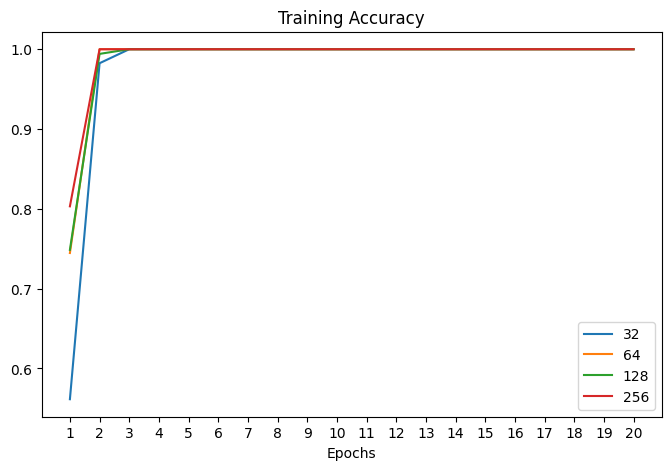

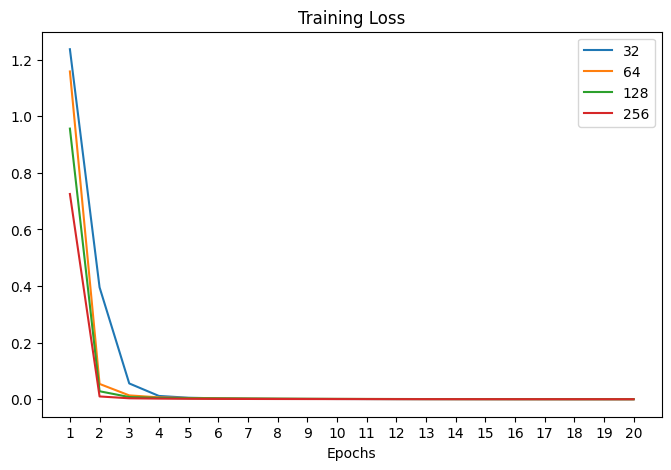

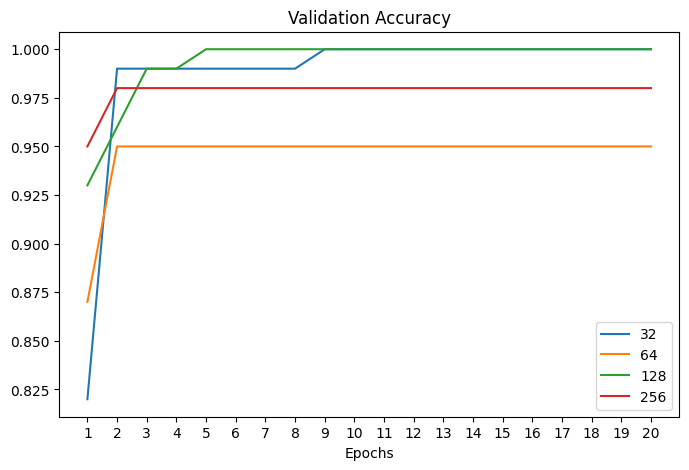

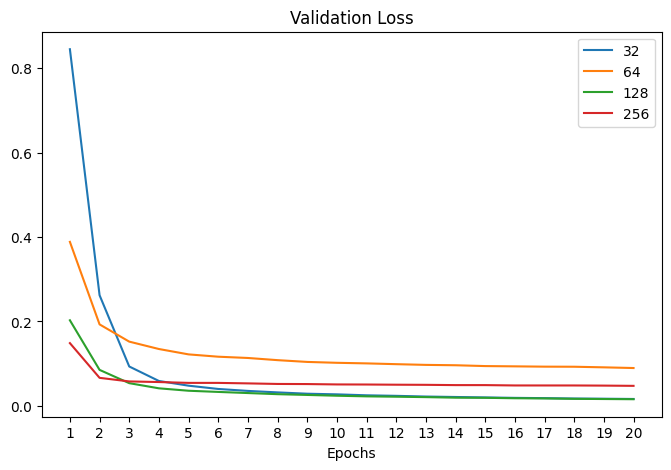

In [14]:
plotting_metrics(scores)

# Dropout

In [18]:
scores={}
inner_size = 128
lr = 1e-05
def make_model(
        base_model = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(150, 150, 3)
        ),
        dense_inner_size = 64,
        learning_rate = 0.001,
        droprate = 0
):
    
    ########################
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training = False)
    vectors = layers.GlobalAveragePooling2D()(base)
    inner = layers.Dense(dense_inner_size, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(5)(drop)
    model = keras.Model(inputs, outputs)

    '][==]'
    ########################
    
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    loss = losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print("Droprate: ", droprate)
    model = make_model(
        dense_inner_size = inner_size,
        learning_rate= lr,
        droprate=droprate
    )
    history = model.fit(train_ds, epochs = 20, validation_data = val_ds)
    scores[droprate] = history.history

Droprate:  0.0
Epoch 1/20
26/26 [==============================] - 14s 286ms/step - loss: 0.8786 - accuracy: 0.7622 - val_loss: 0.5396 - val_accuracy: 0.9200
Epoch 2/20
26/26 [==============================] - 6s 241ms/step - loss: 0.1389 - accuracy: 0.9922 - val_loss: 0.1457 - val_accuracy: 0.9800
Epoch 3/20
26/26 [==============================] - 6s 241ms/step - loss: 0.0221 - accuracy: 1.0000 - val_loss: 0.0884 - val_accuracy: 0.9700
Epoch 4/20
26/26 [==============================] - 6s 241ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0584 - val_accuracy: 0.9800
Epoch 5/20
26/26 [==============================] - 6s 244ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0524 - val_accuracy: 0.9800
Epoch 6/20
26/26 [==============================] - 6s 242ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0478 - val_accuracy: 0.9800
Epoch 7/20
26/26 [==============================] - 6s 245ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0441 - val_accurac

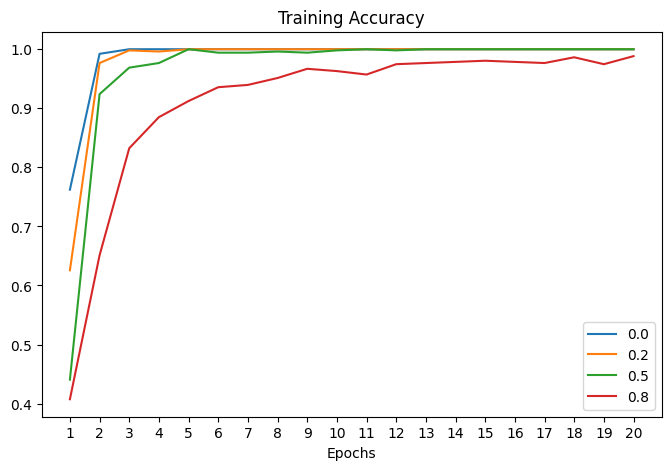

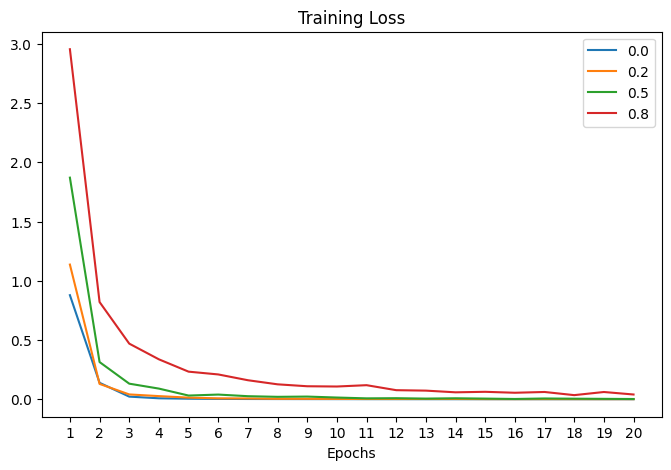

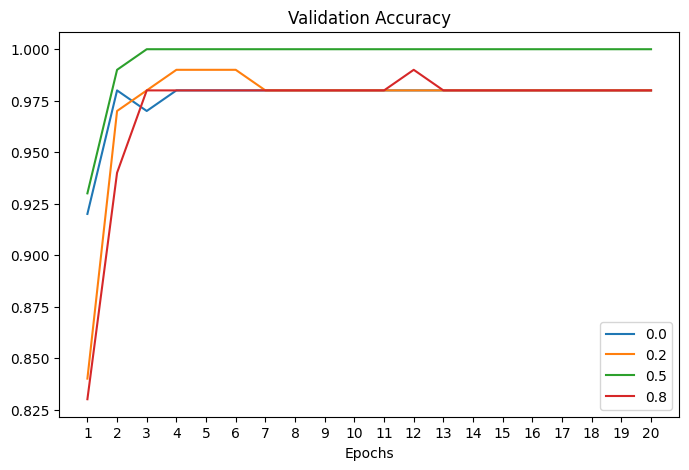

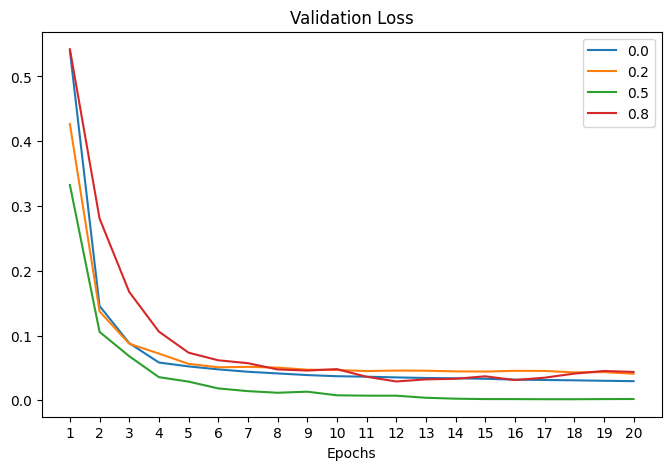

In [19]:
plotting_metrics(scores)

# Checkpointing

In [22]:
inner_size = 128
lr = 1e-05
droprate=0.5
def make_model(
        base_model = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(150, 150, 3)
        ),
        dense_inner_size = 64,
        learning_rate = 0.001,
        droprate = 0
):
    
    ########################
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training = False)
    vectors = layers.GlobalAveragePooling2D()(base)
    inner = layers.Dense(dense_inner_size, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(5)(drop)
    model = keras.Model(inputs, outputs)

    '][==]'
    ########################
    
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    loss = losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

model = make_model(
    dense_inner_size = inner_size,
    learning_rate= lr,
    droprate=droprate
)
checkpoint = keras.callbacks.ModelCheckpoint(
    './models/xception_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(train_ds, 
                    epochs = 50, 
                    validation_data = val_ds, 
                    callbacks=[checkpoint]
)


Epoch 1/50
26/26 [==============================] - 14s 320ms/step - loss: 1.3897 - accuracy: 0.4561 - val_loss: 1.0672 - val_accuracy: 0.7400
Epoch 2/50
26/26 [==============================] - 7s 271ms/step - loss: 0.6572 - accuracy: 0.8460 - val_loss: 0.4935 - val_accuracy: 0.9600
Epoch 3/50
26/26 [==============================] - 7s 271ms/step - loss: 0.2748 - accuracy: 0.9337 - val_loss: 0.1997 - val_accuracy: 0.9800
Epoch 4/50
26/26 [==============================] - 6s 242ms/step - loss: 0.0920 - accuracy: 0.9883 - val_loss: 0.1089 - val_accuracy: 0.9800
Epoch 5/50
26/26 [==============================] - 6s 244ms/step - loss: 0.0541 - accuracy: 0.9942 - val_loss: 0.0846 - val_accuracy: 0.9800
Epoch 6/50
26/26 [==============================] - 6s 241ms/step - loss: 0.0423 - accuracy: 0.9903 - val_loss: 0.0654 - val_accuracy: 0.9800
Epoch 7/50
26/26 [==============================] - 6s 242ms/step - loss: 0.0184 - accuracy: 0.9981 - val_loss: 0.0591 - val_accuracy: 0.9800
Epoch